# NCSU GIS 582: Geospatial Modeling and Analysis

## Flow Modeling: Flow routing, watershed analysis

### Outline:

- cumulative terrain parameters based on flow tracing: definitions and general approach (flow path length, flow accumulation, stream networks, watershed boundaries, ridge lines)
- methods for computing flow direction (D8, Dinf), flow tracing (SFD, MFD, uniform, weighted)
- methods for flow tracing through depressions and flat areas (filling, carving, hybrid, least cost path)
- principle of stream extraction from a DEM and watershed delineation

### Lecture:
[Lecture slides: Flow routing and watershed analysis](https://ncsu-geoforall-lab.github.io/geospatial-modeling-course/lectures/flow.html)

### Supplemental materials:
* [GRASS GIS overview and manual](http://grass.osgeo.org/grass74/manuals/index.html)
* [GRASS book](http://www.grassbook.org/)

* Surface Water Flow Modeling chapter from Petrasova et al., 2018, Tangible Modeling with Open Source GIS. Second Edition. Springer. [Available free through NCSU library](https://link-springer-com.prox.lib.ncsu.edu/book/10.1007/978-3-319-89303-7). or through [Springer](https://link.springer.com/book/10.1007%2F978-3-319-89303-7).
* [Metz, M. et al. (2011) Efficient extraction of drainage networks from massive, radar-based elevation models with least cost path search, Hydrology and Earth System Sciences 15, pp. 667-678.](https://www.hydrol-earth-syst-sci.net/15/667/2011/hess-15-667-2011.html)
* [J Jasiewicz, M Metz, 2011: A new GRASS GIS toolkit for Hortonian analysis of drainage networks, Computers and Geosciences.https://doi.org/10.1016/j.cageo.2011.03.003](https://www.sciencedirect.com/science/article/pii/S0098300411000975?via%3Dihub)
* [Nobre et al. 2011, Height Above the Nearest Drainage – a hydrologically relevant new terrain model, Journal of Hydrology,404(1-2), p. 13-29.](https://www.sciencedirect.com/science/article/pii/S0022169411002599?via%3Dihub)

## Start GRASS GIS

Create a new mapset to run your analysis.

In [1]:
!grass -e -c ~/grassdata/nc_spm_08_grass7/HW_7A_Flow_Modeling

Creating new GRASS GIS mapset <HW_7A_Flow_Modeling>...


The `!` symbole in front of `grass` indicates that we are running a command from the terminal.

In [5]:
import subprocess
import sys

# Ask GRASS GIS where its Python packages are.
# FOR WINDOWS:
# grass_call = "grass80"
# shell_setting = True
# FOR MAC/LINUX
grass_call = "grass"
shell_setting = False

sys.path.append(
    subprocess.check_output([grass_call, "--config", "python_path"], text=True, shell=shell_setting).strip()
)

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
gj.init("~/grassdata", "nc_spm_08_grass7", "HW_7A_Flow_Modeling")


## Compute flow direction, flow accumulation and subwatersheds

Compute flow direction, flow accumulation and subwatersheds with approx. size of 10000 cells from 30m NED.

In [8]:
%%bash
g.region raster=elev_ned_30m -p
r.watershed -s elevation=elev_ned_30m threshold=10000 accumulation=accum_10K drainage=draindir_10K basin=basin_10K --quiet

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      228500
south:      215000
west:       630000
east:       645000
nsres:      30
ewres:      30
rows:       450
cols:       500
cells:      225000


Extract more detailed streams from flow accumulation raster: 

In [9]:
!r.mapcalc "streams_der_30m = if(abs(accum_10K) > 100, 1, null())"

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


Convert to vector format and display results along with the official Wake county streams (red): 

In [12]:
%%bash
r.to.vect -s basin_10K output=basin_10K type=area --quiet
r.thin streams_der_30m output=streams_der_30m_t --quiet
r.to.vect -s streams_der_30m_t out=streams_der_30m type=line --quiet

         overwritten


Generate shaded map and display:

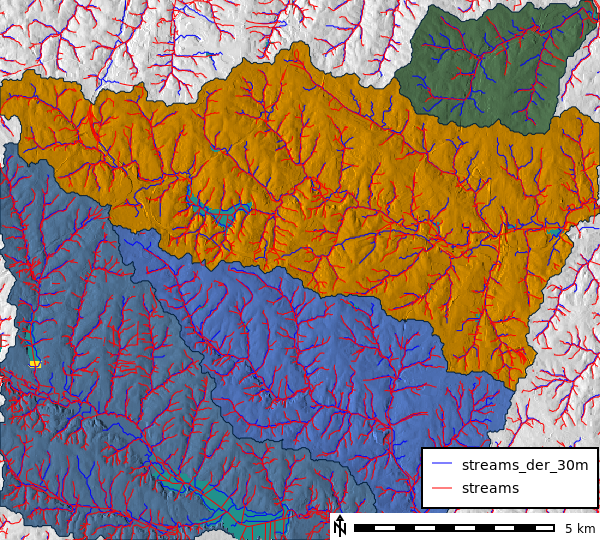

In [34]:
# Create Map instance
mystream_map = gj.Map(filename="output/mystream.png")
# Add the elevation raster to the map
mystream_map.d_his(hue="basin_10K", intensity="elevation_shade", brighten=40)
mystream_map.d_vect(map="basin_10K", type="boundary")
mystream_map.d_rast(map="lakes")
mystream_map.d_vect(map="streams_der_30m", color="blue")
mystream_map.d_vect(map="streams", color="red")
mystream_map.d_legend_vect(at=[72,17], flags="b")
mystream_map.d_barscale(at=[55,5], flags="n")

# Display map
mystream_map.show()

### Question: How do the derived streams compare with the official stream map?

...Write your response here...

### Task: Modify the mapcalc expression to make stream origins fit better with the official stream map.

In [35]:
# Add your code here
# Original expression: r.mapcalc "streams_der_30m = if(abs(accum_10K) > 100, 1, null())"

### Question: Why does your modification make the stream orgins fit better with the offical stream map?

...Write your response here...

## Create map of DEM depressions

Depression filling is often necessary for certain flow routing algorithms but it can alter the elevation data significantly. Find out how extensive the depressions are in our DEM. \

> Note that [r.watershed](https://grass.osgeo.org/grass83/manuals/r.watershed.html) doesn't need any depression filling thanks to its underlying algorithm which uses least cost path to get over depressions.

In [36]:
%%bash
g.region raster=elevation -p
r.fill.dir input=elevation output=elev_fill1 direction=dir1 areas=unres1
r.fill.dir input=elev_fill1 output=elev_fill2 direction=dir2 areas=unres2
r.fill.dir input=elev_fill2 output=elev_fill3 direction=dir3 areas=unres3
r.mapcalc "depr_bin = if((elevation-elev_fill3) < 0., 1, null())"
r.colors depr_bin color=blues

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      228500
south:      215000
west:       630000
east:       645000
nsres:      10
ewres:      10
rows:       1350
cols:       1500
cells:      2025000


Reading input elevation raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Filling sinks...
Determining flow directions for ambiguous cases...
Found 7944 unresolved areas
Repeat to get the final directions...
Found 1013 unresolved areas
Writing output raster maps...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Reading input elevation raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Filling sinks...
Determining flow directions for ambiguous cases...
Found 1013 unresolved areas
Repeat to get the final directions...
Found 93 unresolved areas
Writing output raster maps...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Reading input elevation raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54

Display the new results, compare the derived depressions with actual lakes: 

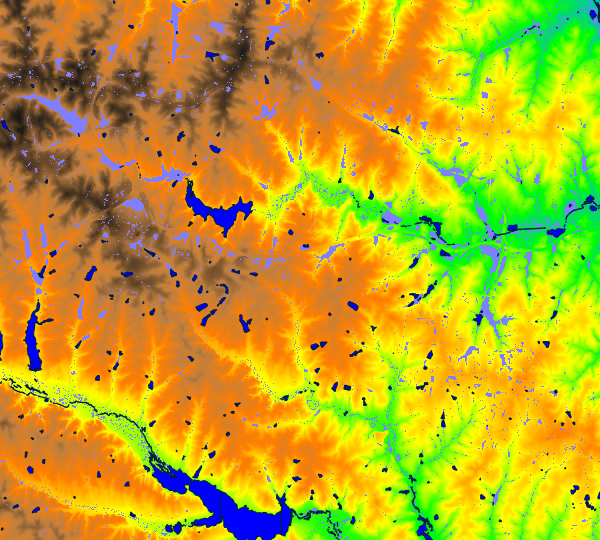

In [39]:
# Create Map instance
depressions_map = gj.Map(filename="output/depressions.png")
# Add the elevation raster to the map
depressions_map.d_rast(map="elevation")
depressions_map.d_rast(map="depr_bin")
depressions_map.d_vect(map="lakes", fill_color="blue", type="area")

# Display map
depressions_map.show()

## Derive contributing area for a given outlet

Set region to the high resolution study area and zoom to it: 

In [41]:
%%bash
g.region rural_1m -p
r.watershed -as elevation=elev_lid792_1m threshold=5000 accumulation=accum_5K drainage=draindir_5K basin=basin_5K --quiet

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      220750
south:      220000
west:       638300
east:       639000
nsres:      1
ewres:      1
rows:       750
cols:       700
cells:      525000


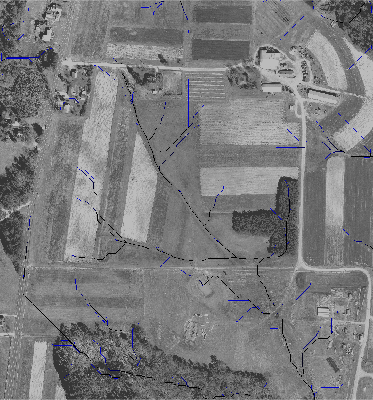

In [46]:
# Create Map instance
accum_5K_map = gj.Map(use_region=True)
# Add the elevation raster to the map
accum_5K_map.d_rast(map="ortho_2001_t792_1m")
accum_5K_map.d_rast(map="accum_5K", values="1500-1000000")

# Display map
accum_5K_map.show()

Identify outlet on the extracted stream.

Create a vector map with the point east=638845.52 north=220085.26 that has accum_5K=224510. 

In [49]:
!v.in.ascii ./inputs/outlet_point.txt output=outletA30 separator=space

Scanning input for column types...
Number of columns: 3
Number of data rows: 1
Importing points...
   0 100
Populating table...
Building topology for vector map <outletA30@HW_7A_Flow_Modeling>...
Registering primitives...


Display the outlet on the map.

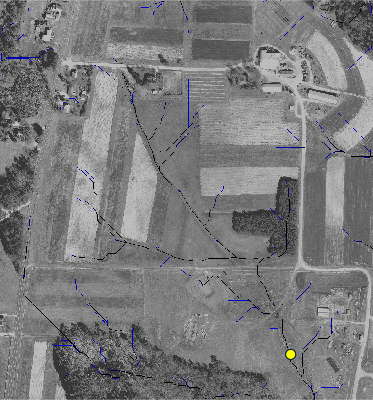

In [54]:
accum_5K_map.d_vect(map="outletA30", fill_color="yellow", type="point", icon="basic/circle", size=10)
accum_5K_map.show()

Delineate the contributing area associated with this outlet and convert it to vector format: 

In [56]:
%%bash
r.water.outlet input=draindir_5K output=basin_A30 coordinates=638845.52,220085.26
r.to.vect -s basin_A30 output=basin_A30 type=area --quiet

   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100


Display watershed boundary along with contours.

In [57]:
!r.contour elev_lid792_1m output=elev_lid792_cont_1m step=1 minlevel=104 --quiet

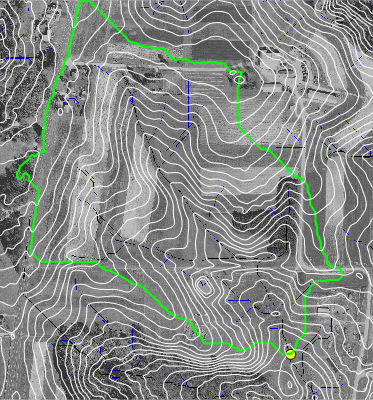

In [59]:
# Create Map instance
accum_5K_map = gj.Map(use_region=True, filename="output/watershedA30.png")
# Add the elevation raster to the map
accum_5K_map.d_rast(map="ortho_2001_t792_1m")
accum_5K_map.d_rast(map="accum_5K", values="1500-1000000")
accum_5K_map.d_vect(map="outletA30", fill_color="yellow", type="point", icon="basic/circle", size=10)
accum_5K_map.d_vect(map="basin_A30", color="green", type="boundary",width=2)
accum_5K_map.d_vect(map="elev_lid792_cont_1m", color="white")
accum_5K_map.show()

Compute the watershed area (category 1)

In [60]:
!r.report basin_A30 unit=h,a

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
+-----------------------------------------------------------------------------+
|                         RASTER MAP CATEGORY REPORT                          |
|LOCATION: nc_spm_08_grass7                           Wed Nov  1 15:32:27 2023|
|-----------------------------------------------------------------------------|
|          north: 220750    east: 639000                                      |
|REGION    south: 220000    west: 638300                                      |
|          res:        1    res:       1                                      |
|-----------------------------------------------------------------------------|
|MASK: none                                                                   |
|-----------------------------------------------------------------------------|
|MAP: Watershed basin (basin_A30 in HW_7A_Flow_Modeling)   

### Question: What is the area of the watershed?

...Write your response here...

## Assess and mitigate impact of the road on flowrouting

Compare the extracted streams (accum > 1500) with official stream data: 

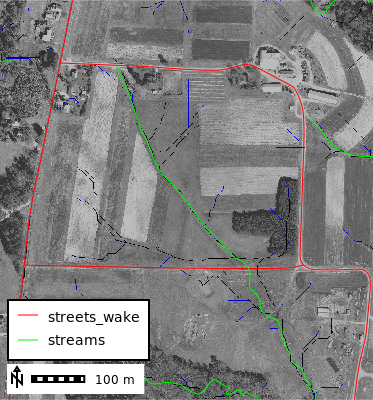

In [79]:
# Create Map instance
streamcompare_map = gj.Map(use_region=True, filename="output/streamcompare.png")

# Add raster layers
streamcompare_map.d_rast(map="ortho_2001_t792_1m")
streamcompare_map.d_rast(map="accum_5K", values="1500-1000000") # accum > 1500

# Add vector layers
streamcompare_map.d_vect(map="streets_wake", color="red")
streamcompare_map.d_vect(map="streams", color="green")

# Add map properties
streamcompare_map.d_legend_vect(at=[5,25], flags="b")
streamcompare_map.d_barscale(at=[2,9], flags="n")

# Display map
streamcompare_map.show()

Carve a pre-defined channel given by the stream data into DEM

In [80]:
%%bash
r.carve raster=elev_lid792_1m vector=streams width=2 depth=0.8 output=elev_lidcarved_1m
r.colors elev_lidcarved_1m raster=elev_lid792_1m

Reading raster map...
  10  21  32  43  54  65  76  87  98 100
Processing lines...
  10  21  32  43  54  65  76WARNING: Vect runs out of region and re-enters - this case is not yet
         implemented.
  87  98 100
Writing raster map...
   0  11  22  33  44  55  66  77  88  99Color table for raster map <elev_lidcarved_1m> set to 'elev_lid792_1m'


Display carved DEM

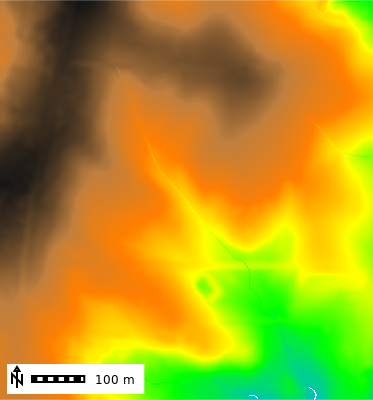

In [81]:
# Create Map instance
elev_lidcarved_1m_map = gj.Map(use_region=True)

# Add raster layers
elev_lidcarved_1m_map.d_rast(map="elev_lidcarved_1m")

# Add map properties
elev_lidcarved_1m_map.d_barscale(at=[2,9], flags="n")

# Display map
elev_lidcarved_1m_map.show()

Extract streams from the carved DEM and compare with the official streams map.

In [83]:
!r.watershed -as elevation=elev_lidcarved_1m accumulation=accumc_5K1m --quiet

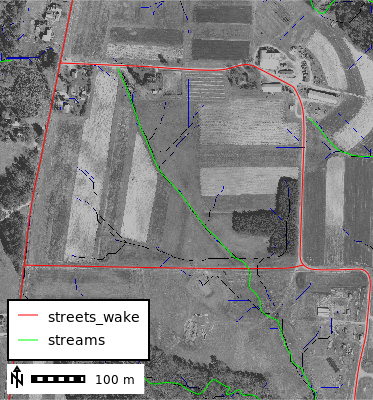

In [97]:
# Create Map instance
streamcarved_map = gj.Map(use_region=True, filename="output/streamcarved.png")

# Add raster layers
streamcarved_map.d_rast(map="ortho_2001_t792_1m")
streamcarved_map.d_rast(map="accum_5K", values="1500-1000000") # accum > 1500
streamcarved_map.d_rast(map="accumc_5K1m", values="1500-1000000") # accum > 1500

# Add vector layers
streamcarved_map.d_vect(map="streets_wake", color="red")
streamcarved_map.d_vect(map="streams", color="green")

# Add map properties
streamcarved_map.d_legend_vect(at=[5,25], flags="b")
streamcarved_map.d_barscale(at=[2,9], flags="n")

# Display map
streamcarved_map.show()

## Question: What is the difference between accum_5K, accumc_5K1m and streams?

...Write your response here...

## Question: Explain the advantage and disadvantage of carving.

...Write your response here...

## Compute refined flow pattern using D-inf

Compare upslope and downslope flow lines:

In [98]:
%%bash
g.region raster=elev_lid792_1m -p
r.flow elevation=elev_lid792_1m flowline=flowlines flowlength=flowlg_1m flowaccumulation=flowacc_1m
r.flow -u elevation=elev_lid792_1m flowlength=flowlgup_1m flowaccumulation=flowaccup_1m

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      220750
south:      220000
west:       638300
east:       639000
nsres:      1
ewres:      1
rows:       750
cols:       700
cells:      525000


Reading input raster map <elev_lid792_1m>...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Calculating...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Writing output raster map <flowacc_1m>...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Building topology for vector map <flowlines@HW_7A_Flow_Modeling>...
Registering primitives...
Reading input raster map <elev_lid792_1m>...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Calculating...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Writing output raster map <flowaccup_1m>...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100


Display maps along with contours to see relation to terrain: 

Display the downslope flowlines.

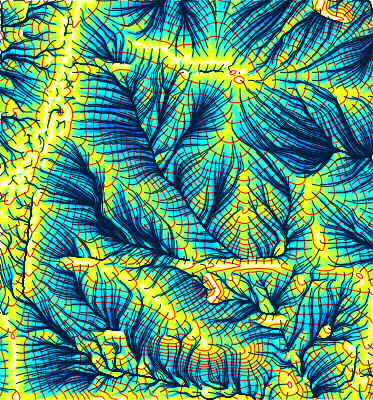

In [99]:
# Create Map instance
flowdown_map = gj.Map(filename="output/flowdown.png")\

flowdown_map.d_rast(map="flowacc_1m")
flowdown_map.d_vect(map="elev_lid792_cont_1m", color="red")
flowdown_map.d_vect(map="flowlines")

# Display map
flowdown_map.show()

Display the upslope flowlines

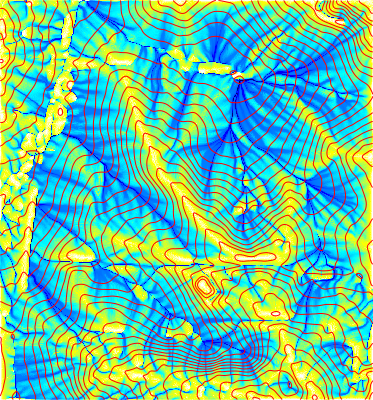

In [100]:
flowlines_map = gj.Map(filename="output/flowlines.png")\

flowlines_map.d_rast(map="flowaccup_1m")
flowlines_map.d_vect(map="elev_lid792_cont_1m", color="red")

# Display map
flowlines_map.show()

### Question: On what type of landform (ridge, valley) they converge?

...Write your response here...

## Compare the multiple flow direction result with D8 and Dinf

In [103]:
!r.watershed -a elevation=elev_lid792_1m threshold=5000 accumulation=accum_mfd_5K1m --quiet

Display multiple flow direction.

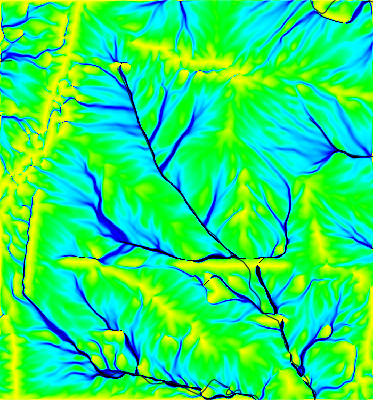

In [105]:
# Create Map instance
stream_mfd_map = gj.Map(filename="output/stream_mfd.png")
stream_mfd_map.d_rast(map="accum_mfd_5K1m")
stream_mfd_map.d_vect(map="streams")

# Display map
stream_mfd_map.show()

Display single flow direction

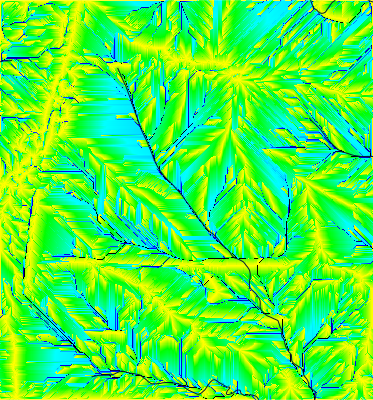

In [110]:
# Create Map instance
stream_sfd_map = gj.Map(filename="output/stream_sfd.png")\

stream_sfd_map.d_rast(map="accum_5K")
stream_sfd_map.d_vect(map="streams")

# Display map
stream_sfd_map.show()

### Question: Compare the results of r.watershed: accum_5K and accum_mfd_5K1m. Why are they different, which is more accurate and why?

...Write your response here...

## Compute wetness index

In [111]:
%%bash
g.region rural_1m -p
r.topidx elev_lid792_1m output=wetness_1m
r.colors map=wetness_1m color=water

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      220750
south:      220000
west:       638300
east:       639000
nsres:      1
ewres:      1
rows:       750
cols:       700
cells:      525000


Reading elevation map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Calculating...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Number of sinks or boundaries: 53
Writing topographic index map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Color table for raster map <wetness_1m> set to 'water'


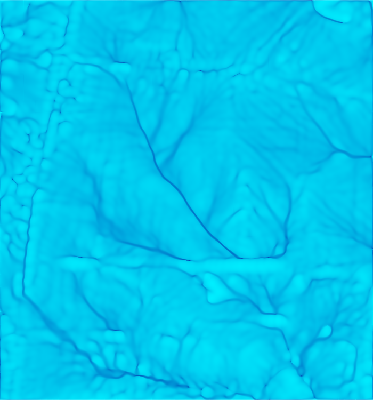

In [114]:
# Create Map instance
wetness_map = gj.Map(filename="output/wetness.png")
wetness_map.d_rast(map="wetness_1m")
# Display map
wetness_map.show()

Display `elev_lid792_1m` in 3D and drape over `wetness_1m` as color.\
Note: switch off all layers except for elev_lid792_1m

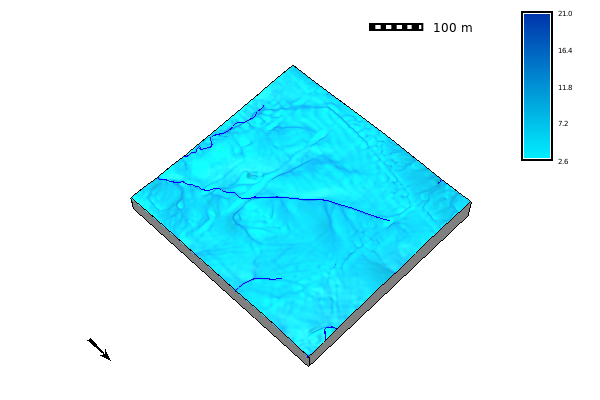

In [119]:
elevation_3dmap = gj.Map3D(filename="output/3dWetnessIndex.png")
# Full list of options m.nviz.image
# https://grass.osgeo.org/grass83/manuals/m.nviz.image.html
elevation_3dmap.render(
    elevation_map="elev_lid792_1m",
    color_map="wetness_1m",
    perspective=20,
    height=3000,
    vline="streams",
    vline_color="blue",
    vpoint="usgsgages",
    vpoint_color="red",
    vpoint_marker="sphere",
    vpoint_size=200,
    fringe=['ne','nw','sw','se'],
    arrow_position=[100,50],
)
elevation_3dmap.overlay.d_legend(raster="wetness_1m", at=(60, 97, 87, 92))
elevation_3dmap.overlay.d_barscale(at=(60, 97, 87, 92))

elevation_3dmap.show()

**Compute the wettness index using the formula in the lecture**

> hint: you will need to compute slope using `elev_lid792_1m` and use `accum_mfd_5K1m` as contributing area.

Check the values by comparing your output with wetness_1m computed with r.topidx.

[r.topidx](https://grass.osgeo.org/grass83/manuals/r.topidx.html) creates topographic index (wetness index), ln(a/tan(beta)), map from elevation map

where
```
    a: the area of the hillslope per unit contour length that drains through any point,

    tan(beta): the local surface topographic slope (delta vertical) / (delta horizontal).
```

### Task: Compute and Compare Wetness Indices

In [126]:
## Add your code here

## Create a map of flooded area

Create a map of flooded area for a given water level and seed point: 

In [121]:
!r.lake elevation=elev_lid792_1m water_level=113.5 lake=flood1 coordinates=638728,220278

   5  11  17  23  29  35  41  47  53  59  65  71  77  83  89  95 100
 100
   5  11  17  23  29  35  41  47  53  59  65  71  77  83  89  95 100
Lake depth from 0.000000 to 0.860382 (specified water level is taken as
zero)
Lake area 2245.000000 square meters
Lake volume 891.858521 cubic meters
Volume is correct only if lake depth (terrain raster map) is in meters


Display flooded area

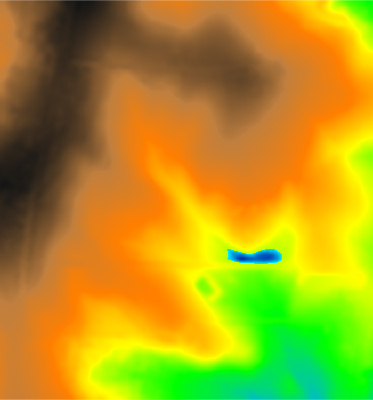

In [122]:
# Create Map instance
floodedarea_map = gj.Map(filename="output/floodedarea.png")\

floodedarea_map.d_rast(map="elev_lid792_1m")
floodedarea_map.d_rast(map="flood1")

# Display map
floodedarea_map.show()

### Task: Increase water level to 113.7m and 115.0m and create flooded area maps at these two levels. Include the maps of flooded areas at these water levels in your report. 

In [123]:
## Add your code here